# Model Parallel Multi-GPU Training 

We have created a custom implementation of the ResNet 50 Model, and split the layers across multiple GPUs to perform model parallel training, using automatic mixed precision.



In [1]:
import os
import shutil
import pandas as pd
import dask.array as da
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast
from torchvision.models import resnet50
import torch.multiprocessing as mp
import torch.distributed as dist
import torch.optim as optim
import torch.nn.functional as F 
import matplotlib.pyplot as plt
import time

### Data Augmentation

In [2]:

# Split the dataset into train, validation and test
def create_splits(data_dir, output_dir, train_size=0.7, val_size=0.15, test_size=0.15):
    classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    splits = {'train': train_size, 'val': val_size, 'test': test_size}

    assert sum(splits.values()) == 1, "Sum of split sizes should be 1."

    # Output directories for the splits
    for split in splits.keys():
        for cls in classes:
            os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)

    # Iterate over each class directory
    for cls in classes:
        class_dir = os.path.join(data_dir, cls)
        images = [img for img in os.listdir(class_dir) if img.lower().endswith(('png', 'jpg', 'jpeg'))]
        # Stratified splits
        train_val, test = train_test_split(images, test_size=splits['test'], random_state=42, stratify=None)
        train, val = train_test_split(train_val, test_size=splits['val'] / (splits['train'] + splits['val']), random_state=42, stratify=None)

        # Function to copy files to directories
        def copy_files(files, split):
            for f in files:
                src = os.path.join(class_dir, f)
                dst = os.path.join(output_dir, split, cls, f)
                shutil.copy(src, dst)

        # Copy files to respective split directories
        copy_files(train, 'train')
        copy_files(val, 'val')
        copy_files(test, 'test')


data_dir = 'dataset/'
output_dir = 'dataset_splits/'
create_splits(data_dir, output_dir)

In [3]:

# Data Augmentation using dask
def get_data_loader(batch_size, data_path, train=True):
    print("get data loader")
    if train:
        transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    else:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    
    dataset = datasets.ImageFolder(data_path, transform=transform)
        
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=train, num_workers=4, pin_memory=True)
    return data_loader




### Custom implementation of ResNet 50

In [4]:
# Custom implementation of ResNet
class CustomResNet(nn.Module):
    def __init__(self):
        super(CustomResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # First half of ResNet layers
        self.layer1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )
        
        # Second half of ResNet layers
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, 6)  

    # Forward Pass
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [5]:
# Function to calculate GPU utilization
def measure_gpu_utilization(device_idx):
    gpu_utilization = torch.cuda.memory_allocated(device_idx) / torch.cuda.get_device_properties(device_idx).total_memory * 100
    return gpu_utilization


In [39]:
# Initialize the model
model = CustomResNet()

# Split model across 2 GPUs
device1 = torch.device("cuda:0")
device2 = torch.device("cuda:1")
# Layers on GPU1
model.conv1.to(device1)
model.bn1.to(device1)
model.layer1.to(device1)

# Layers on GPU2
model.layer2.to(device2)
model.avgpool.to(device2)
model.fc.to(device2)

# Stochastic Gradient optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Loss function
criterion = nn.CrossEntropyLoss()

# to store loss values and GPU utilization
train_losses = []
val_losses = []
gpu_utilization = []

log_interval = 100

batch_size = 256
world_size = 2

# train data loader
train_loader = get_data_loader(batch_size // world_size, train_dir, train=True)
# validation data loader
val_loader = get_data_loader(batch_size // world_size, val_dir, train=False)

# Initialize the gradient scaler for AMP
scaler = GradScaler()  

epochs = 10

# Training loop
for epoch in range(epochs):
    train_loss = 0.0
    val_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device1), target.to(device1)  # Move data to the first GPU
        
        # Forward pass through the layers on the first GPU (device1)
        with torch.cuda.amp.autocast():  # automatic mixed precision
            x = model.conv1(data)
            x = model.bn1(x)
            x = model.relu(x)
            x = model.maxpool(x)
            x = model.layer1(x)
        
        # Moving the intermediate tensor 'x' to the second GPU (device2)
        x = x.to(device2)
        
        # Continue forward pass through the layers on the second GPU (device2)
        with torch.cuda.amp.autocast(): 
            x = model.layer2(x)
            x = model.avgpool(x)
            x = torch.flatten(x, 1)
            output = model.fc(x)
            
        # Moving target to the second GPU (device2) for loss computation
        target = target.to(device2)
        
        # Calculate the loss on device2
        loss = criterion(output, target)
        
        # Backward pass and optimization on device2
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # train loss 
        train_loss += loss.item()
        
        # validation loss
        val_loss += loss.item()
            
        if batch_idx % log_interval == 0:
            print(f"Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}")
    
    # append to list
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    # GPU utilization
    current_utilization_device1 = measure_gpu_utilization(device1.index)
    current_utilization_device2 = measure_gpu_utilization(device2.index)
    gpu_utilization.append((current_utilization_device1, current_utilization_device2))



get data loader
data loader.............
return loader ........
get data loader
data loader.............
return loader ........
Epoch 0, Batch 0, Loss: 2.333984375
Epoch 0, Batch 100, Loss: 1.8037109375
Epoch 0, Batch 200, Loss: 1.806640625
Epoch 0, Batch 300, Loss: 1.7900390625
Epoch 0, Batch 400, Loss: 1.7607421875
Epoch 0, Batch 500, Loss: 1.8115234375
Epoch 1, Batch 0, Loss: 1.7900390625
Epoch 1, Batch 100, Loss: 1.7548828125
Epoch 1, Batch 200, Loss: 1.765625
Epoch 1, Batch 300, Loss: 1.775390625
Epoch 1, Batch 400, Loss: 1.7705078125
Epoch 1, Batch 500, Loss: 1.7724609375
Epoch 2, Batch 0, Loss: 1.736328125
Epoch 2, Batch 100, Loss: 1.779296875
Epoch 2, Batch 200, Loss: 1.73828125
Epoch 2, Batch 300, Loss: 1.71875
Epoch 2, Batch 400, Loss: 1.794921875
Epoch 2, Batch 500, Loss: 1.751953125
Epoch 3, Batch 0, Loss: 1.75
Epoch 3, Batch 100, Loss: 1.6748046875
Epoch 3, Batch 200, Loss: 1.763671875
Epoch 3, Batch 300, Loss: 1.76953125
Epoch 3, Batch 400, Loss: 1.712890625
Epoch 3, Batc

### Model Evaluation

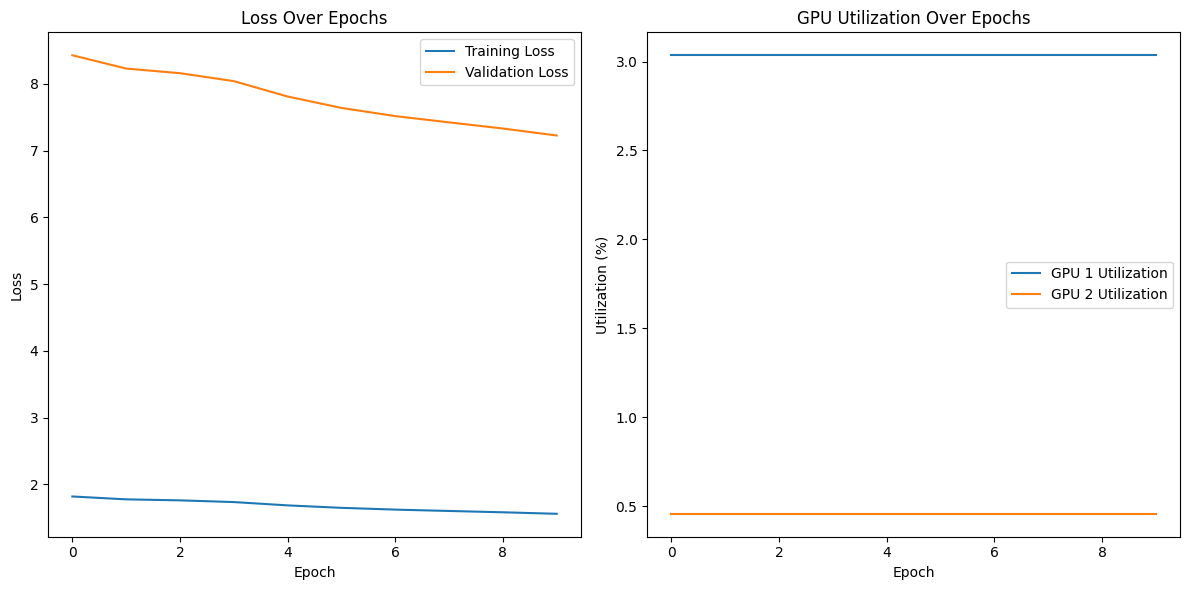

In [45]:
# Plot Training and Validation Losses
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot GPU Utilization
gpu_util1, gpu_util2 = zip(*gpu_utilization)
epochs = range(len(gpu_util1))
plt.subplot(1, 2, 2)
plt.plot(epochs, gpu_util1, label='GPU 1 Utilization')
plt.plot(epochs, gpu_util2, label='GPU 2 Utilization')
plt.title('GPU Utilization Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Utilization (%)')
plt.legend()

plt.savefig('Loss_GPU_util.png')

plt.tight_layout()
plt.show()